# Consumer price index forecasting

## Overview 
This Notebook presents a pipeline for forecasting the Consumer Price index (CPI), a key measure of inflation, over the next year. It generates predictions for the Year-on-Year CPI at 12,9,6 and 3-month intervals, with corresponding visualizations to illustrate projected trends.


Clients could use the generated predictions as an analytical insight on inflation trends, and/or when making informed decisions on setting interest rates.

The dataset used could be sourced from the [UK Office for National Statistics (ONS)] (https://www.ons.gov.uk/economy/inflationandpriceindices/datasets/consumerpriceinflation) Feel free to experiment with other datasets providing inflation measures, should they fit a desired statistical objective.

## Setup 
### Dependencies 

This work uses the following library versions: 

* turintech-evoml-client
* pandas 
* matplotlib 
* plotly 
* nbformat (if using xls data)
* python-dotenv (for loading environment variables)
###Credentials

You will also require:
* A URL for an instance of the evoML platform (e.g. https://evoml.ai)
* Your evoML username and password

**Environment Setup:**
Create a `.env` file in the project root directory with your credentials:
```
EVOML_USERNAME=your_username_here
EVOML_PASSWORD=your_password_here
```

The notebook will automatically load these credentials from the `.env` file.

In [29]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from typing import Final
import evoml_client as ec 
from evoml_client.trial_conf_models import BudgetMode, SplitMethodOptions
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import nbformat as nbf
import math
from dataclasses import dataclass
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

API_URL: Final[str] = "https://evoml.ai"
EVOML_USERNAME: Final[str] = os.getenv("EVOML_USERNAME", "")
EVOML_PASSWORD: Final[str] = os.getenv("EVOML_PASSWORD", "")

# Connect to evoML platform
ec.init(base_url=API_URL, username=EVOML_USERNAME, password=EVOML_PASSWORD)

True

### Data loading and manipulation
We first retrieve the downloaded data and select the relevant sheet name (Table 57, in this case) to extract the CPI summary of all items for the time period between between 1988 and 2025. 

We then further convert the date column into a datetime format and we create a dataframe with our time column and dependent variable only. 

In [30]:
xls = pd.ExcelFile("../data/consumer-price-inflation-ONS.xlsx", engine="openpyxl")
CPI_UK = pd.read_excel("../data/consumer-price-inflation-ONS.xlsx", sheet_name="Table 57", skiprows=6, engine="openpyxl")
#print(CPI_UK['name'].tail(15)) #The last 14 rows of data are not relevant to the analysis
CPI_UK = CPI_UK.drop(CPI_UK.tail(14).index)
CPI_UK.shape
CPI_UK.to_csv("CPI_UK.csv", index=False)

In [31]:
#Time column manipulation:
CPI_UK['name'] = pd.to_datetime(CPI_UK['name'])
CPI_UK['name'] = CPI_UK['name'].dt.strftime('%Y-%m') #Removing the 00:00:00 timestamp from the date
CPI_UK.rename(columns={"name": "Date_CPI"}, inplace=True)

In [32]:
#Creating the final dataframe for analysis: 
CPI_UK = CPI_UK.copy()
CPI_UK_single = CPI_UK[['Date_CPI', 'CPI ALL ITEMS']]

In [19]:
CPI_UK

,index date,Date_CPI,CPI ALL ITEMS,FOOD AND NON-ALCOHOLIC BEVERAGES,FOOD,BREAD & CEREALS,MEAT,FISH,"MILK, CHEESE & EGGS",OILS & FATS,...,Durables,Semi-Durables,Non-Durables,"Energy, Food, Alcohol & Tobacco",Energy & Non-processed Food,Energy & Seasonal Food,"Education, Health & Social Protection",CPI excluding tobacco,Industrial Goods,Miscellaneous and Other Services
0,198801.0,1988-01,48.395,48.004,48.226,50.053,53.741,43.321,48.488,45.461,...,114.318,138.376,48.751,36.743,37.009,33.856,22.302,50.142,79.030,26.499
1,198802.0,1988-02,48.551,48.275,48.481,50.353,53.386,43.670,48.523,45.921,...,114.255,139.398,49.000,36.824,37.043,33.966,22.318,50.308,79.181,26.639
2,198803.0,1988-03,48.717,48.424,48.622,50.311,53.721,43.130,48.551,46.108,...,115.203,140.239,49.140,36.892,37.102,33.971,22.432,50.487,79.543,26.692
3,198804.0,1988-04,49.280,48.693,48.874,50.548,53.736,43.151,48.861,46.249,...,116.535,140.521,49.430,37.260,37.490,34.433,22.486,51.061,80.210,26.825
4,198805.0,1988-05,49.529,48.820,48.954,50.970,54.186,42.799,48.770,46.346,...,117.061,141.845,49.698,37.430,37.661,34.550,22.519,51.322,80.779,26.943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,202409.0,2024-09,134.215,136.316,135.870,136.038,127.820,134.181,141.606,187.465,...,119.984,119.601,128.414,141.418,139.258,141.645,137.524,133.394,125.297,126.755
441,202410.0,2024-10,135.015,136.512,135.998,136.106,127.829,132.271,141.526,187.015,...,119.799,120.918,128.732,143.142,142.478,145.641,139.775,134.204,126.592,128.422
442,202411.0,2024-11,135.140,137.142,136.733,137.349,127.089,133.411,143.485,190.346,...,119.652,121.445,128.667,143.978,142.712,146.113,139.874,134.246,126.773,128.574
443,202412.0,2024-12,135.552,137.801,137.451,138.316,127.241,132.359,143.690,193.049,...,120.423,121.054,129.353,144.551,143.436,146.975,140.202,134.644,127.166,128.771


### Dependent variable manipulation 
In order to retrieve a valuable estimate of inflation, we:
1. Compute the 12-month rolling inflation rate from the Consumer Price index, which can be expressed with the following equation: 
$$
 \frac{CPI_t - CPI_{t-1}}{CPI_{t-1}} \times 100 
$$

In order to avoid null values, we add a small offset to the product (epislon value). 

2. In order to ensure stationarity, we apply seasonal differecing to further detrend the data by removing annual seasonality. 
$$
\Delta_{12} \pi_t = \pi_t - \pi_{t-12}
$$
We visualize both results and prepare the final dataframe for analysis. 


/tmp/ipykernel_433397/3866308925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPI_UK_single['Date_CPI'] = pd.to_datetime(CPI_UK_single['Date_CPI'])


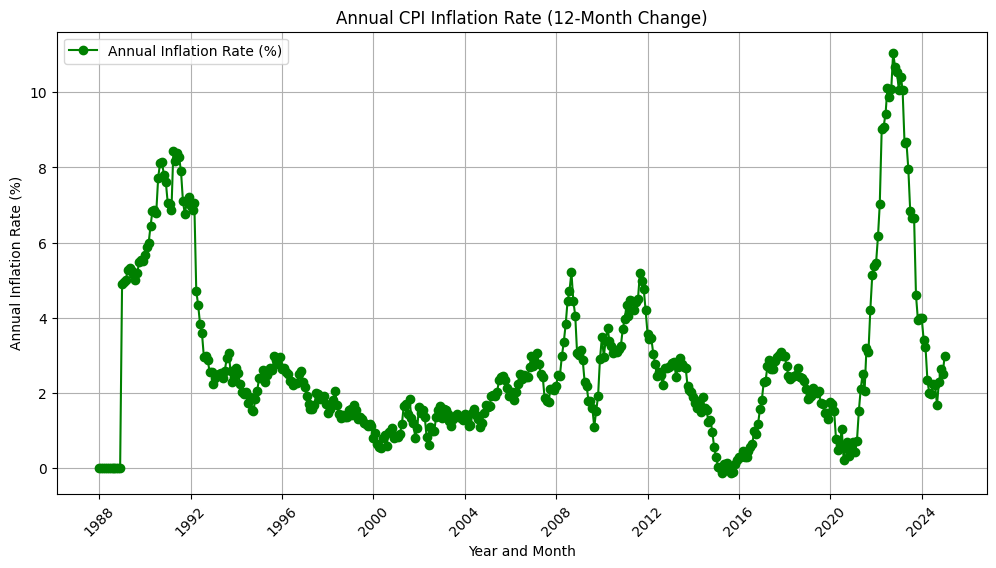

In [33]:

# sort the data by date
CPI_UK_single['Date_CPI'] = pd.to_datetime(CPI_UK_single['Date_CPI'])
CPI_UK_single = CPI_UK_single.sort_values(by='Date_CPI')

# Compute the 12-month rolling inflation rate 
epsilon = 1e-10  # Define a small epsilon value

CPI_UK_single['CPI_Annual_Change'] = (CPI_UK_single['CPI ALL ITEMS'] - CPI_UK_single['CPI ALL ITEMS'].shift(12)) / (CPI_UK_single['CPI ALL ITEMS'].shift(12) + epsilon) * 100

# Replace missing values
CPI_UK_single['CPI_Annual_Change'] = CPI_UK_single['CPI_Annual_Change'].fillna(epsilon)

# Plot 
plt.figure(figsize=(12, 6))
plt.plot(CPI_UK_single['Date_CPI'], CPI_UK_single['CPI_Annual_Change'], marker='o', linestyle='-', color='green', label='Annual Inflation Rate (%)')

plt.title('Annual CPI Inflation Rate (12-Month Change)')
plt.xlabel('Year and Month')
plt.ylabel('Annual Inflation Rate (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

In [44]:
# Reading the data 
xls = pd.ExcelFile("../data/consumer-price-inflation-ONS.xlsx", engine="openpyxl")
CPI_UK = pd.read_excel("../data/consumer-price-inflation-ONS.xlsx", sheet_name="Table 57", skiprows=6, engine="openpyxl")

# Dropping columns 
#print(CPI_UK['name'].tail(15)) #The last 14 rows of data are not relevant to the analysis
CPI_UK = CPI_UK.drop(CPI_UK.tail(14).index)

# Converting the time column to datetime format 
CPI_UK['name'] = pd.to_datetime(CPI_UK['name'])
CPI_UK['name'] = CPI_UK['name'].dt.strftime('%Y-%m') #Removing the 00:00:00 timestamp from the date
CPI_UK.rename(columns={"name": "Date_CPI"}, inplace=True)

# Creating the df for exploratory analysis 
CPI_UK = CPI_UK.copy()
cpi_df = CPI_UK[['Date_CPI', 'CPI ALL ITEMS']]

In [46]:

# Small epsilon to avoid division by zero
epsilon = 1e-10

# 1. Compute 12-month rolling inflation rate
cpi_df['CPI_Annual_Change'] = (
    (cpi_df['CPI ALL ITEMS'] - cpi_df['CPI ALL ITEMS'].shift(12)) / 
    (cpi_df['CPI ALL ITEMS'].shift(12) + epsilon) * 100
)
# First shift creates NaN values for first 12 months (Jan-Dec 1988)
# Remove initial NaN values
cpi_df = cpi_df.dropna().reset_index(drop=True).copy()

# 2. Apply seasonal differencing for stationarity
# This creates another 12 months of NaN values (Jan-Dec 1989)
cpi_df['Delta_CPI_Annual_Change'] = cpi_df['CPI_Annual_Change'].diff(12)

# Remove additional NaN values from differencing
cpi_df = cpi_df.dropna().reset_index(drop=True).copy()

print(cpi_df.head())


  Date_CPI  CPI ALL ITEMS  CPI_Annual_Change  Delta_CPI_Annual_Change
0  1992-01         61.423           6.969576                -0.085256
1  1992-02         61.707           6.870454                -0.146635
2  1992-03         62.020           7.054701                 0.200762
3  1992-04         62.694           4.711640                -3.732330
4  1992-05         62.911           4.340399                -3.839381


In [34]:
CPI_UK_single.to_csv("CPI_UK_single.csv", index=False)

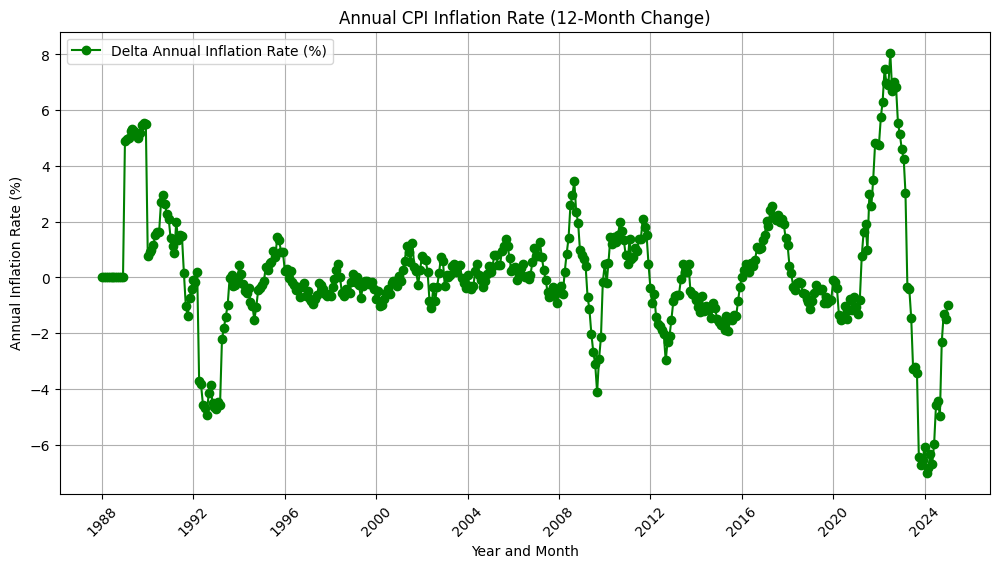

In [35]:
# Apply seasonal differencing:
CPI_UK_single['Delta_CPI_Annual_Change'] = CPI_UK_single['CPI_Annual_Change'].diff(12)
CPI_UK_single['Delta_CPI_Annual_Change'] = CPI_UK_single['Delta_CPI_Annual_Change'].fillna(epsilon)

# Plot 
plt.figure(figsize=(12, 6))
plt.plot(CPI_UK_single['Date_CPI'], CPI_UK_single['Delta_CPI_Annual_Change'], marker='o', linestyle='-', color='green', label='Delta Annual Inflation Rate (%)')

plt.title('Annual CPI Inflation Rate (12-Month Change)')
plt.xlabel('Year and Month')
plt.ylabel('Annual Inflation Rate (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

In [36]:
#Prepare the final dataframe for analysis:
CPI_Delta_YoY = CPI_UK_single[['Date_CPI', 'Delta_CPI_Annual_Change']]
CPI_Delta_YoY

,Date_CPI,Delta_CPI_Annual_Change
0,1988-01-01,1.000000e-10
1,1988-02-01,1.000000e-10
2,1988-03-01,1.000000e-10
3,1988-04-01,1.000000e-10
4,1988-05-01,1.000000e-10
...,...,...
440,2024-09-01,-4.971836e+00
441,2024-10-01,-2.318886e+00
442,2024-11-01,-1.318865e+00
443,2024-12-01,-1.490282e+00


In [37]:
#Upload the dataset to EvoML 
dataset = ec.Dataset.from_pandas(CPI_Delta_YoY, name="CPI_Dataset_Delta")
dataset.put()
dataset.wait()
print(f"Dataset URL: {API_URL}/platform/datasets/view/{dataset.dataset_id}")

Dataset URL: https://evoml.ai/platform/datasets/view/68bf2f946af502fa8952f0f7


## Trial configuration
1. We create a universal function which will allow us to define four different trials, each with a Time series horizon of 12, 9, 6 and 3 months into the future, respectively. For this example, we have kept the window size the same (=6) and have chosen regularized regression models with the aim of ensuring generalization and handling milticolinearity concerns. 
2. We then create another function to store the metrics from each trial we have generated, so we could later on use it for our visualization. 

In [38]:

def config_trial(dataset_id, target_col, trial_name, models, train_percentage=0.8, budget_mode=BudgetMode.fast, loss_funcs=["Root Mean Squared Error"], is_timeseries=True, TimeseriesHorizon=12):
    '''
    Configures and runs a trial with the specified parameters.

    Params:
    dataset_id: str - the dataset ID
    target_col: str - the target column name
    trial_name: str - the name of the trial
    models: list - a list of model names
    train_percentage: float - the percentage of the dataset to use for training
    budget_mode: BudgetMode - the budget mode
    loss_funcs: list - a list of loss functions
    is_timeseries: bool - whether the dataset is a time series
    TimeseriesHorizon: int - the time series horizon (default is 12)

    Returns:
    trial: Trial - the trial object
    '''
    try:
        config = ec.TrialConfig.with_models(
            models=models,
            task=ec.MlTask.regression,
            budget_mode=budget_mode,
            loss_funcs=loss_funcs,
            dataset_id=dataset_id,
            is_timeseries=is_timeseries,
        )
        config.options.timeSeriesWindowSize = 6
        config.options.timeSeriesHorizon = TimeseriesHorizon
        config.options.splittingMethodOptions = SplitMethodOptions(method="percentage", trainPercentage=train_percentage)
        config.options.enableBudgetTuning = False
        
        trial, _ = ec.Trial.from_dataset_id(
            dataset_id,
            target_col=target_col,
            trial_name=trial_name,
            config=config,
        )

        trial.run(timeout=900)
        return trial

    except Exception as e:
        print(f"An error occurred while building the trial: {e}")
        return None

In [39]:
def process_trial(trial, trial_number, results):
    if trial:
        # Proceed with further steps like getting metrics
        metrics_df = trial.get_metrics_dataframe()
        results[f'metrics_df_{trial_number}'] = metrics_df
        
        # Get the best model
        best_model = trial.get_best()
        best_model.build_model()
        results[f'best_model_{trial_number}'] = best_model
        
        # Extract model representation dictionary
        model_rep_dict = best_model.model_rep.__dict__
        
        # Get the best model name
        best_model_name = model_rep_dict.get('name')
        results[f'best_model_name_{trial_number}'] = best_model_name
        
        # Get the best model MSE on the test set
        best_model_mse_test = model_rep_dict.get('metrics', {}).get('regression-mse', {}).get('test', {}).get('average')
        results[f'best_model_mse_test_{trial_number}'] = best_model_mse_test
        
        # Calculate the RMSE
        best_model_rmse_test = math.sqrt(best_model_mse_test)
        results[f'best_model_rmse_test_{trial_number}'] = best_model_rmse_test
        
        # Print the results
        print(f"Best Model Name ({trial_number}): {best_model_name}")
        print(f"Best Model MSE (Test) ({trial_number}): {best_model_mse_test}")
        print(f"Best Model RMSE (Test) ({trial_number}): {best_model_rmse_test}")
    else:
        print(f"Trial {trial_number} unsuccessful.")

# Dictionary to store results
results = {}


## Defining and processing trials
We will now create our four trials with a varying predictive horizon for the future, and extract their metrics. We recommend running these one after the other, as it can be quite time consuming if ran simultaneously. 

In [40]:
trial_12 = config_trial(dataset.dataset_id, "Delta_CPI_Annual_Change", "Inflation_Rate_Delta_12", ["ridge_regressor", "lasso_regressor", "elastic_net_regressor"], 0.8, BudgetMode.fast, ["Root Mean Squared Error"], True, 12)
process_trial(trial_12, 12, results)
# Access the trial results
metrics_df_12 = results['metrics_df_12']
best_model_12 = results['best_model_12']
best_model_name_12 = results['best_model_name_12']
best_model_rmse_test_12 = results['best_model_rmse_test_12']

2025-09-08 20:34:40.386 | INFO     | evoml_client.trial_config:get_allowed_metaml_models:72 - Model validation couldn't take place because evoml-client is installed. Please install evoml-client[full] which allow further validations. Continuing without applying strict validations on models.


An error occurred while building the trial: local variable 'ClassifierName' referenced before assignment
Trial 12 unsuccessful.


KeyError: 'metrics_df_12'

In [ ]:
trial_9 = config_trial(dataset.dataset_id, "Delta_CPI_Annual_Change", "Inflation_Rate_Delta_9", ["ridge_regressor", "lasso_regressor", "elastic_net_regressor"], 0.8, BudgetMode.fast, ["Root Mean Squared Error"], True, 9)
process_trial(trial_9, 9, results)
best_model_9 = results['best_model_9']
best_model_name_9 = results['best_model_name_9']
best_model_rmse_test_9 = results['best_model_rmse_test_9']

2025-03-04 12:40:44.921 - INFO     - evoml_client.pipeline.get_pipeline_report_when_ready:59 - Waiting for pipeline report with id 91ff64fb-f100-40ea-b557-629c44ec6ef2 to be ready.
2025-03-04 12:40:45.039 - INFO     - evoml_client.pipeline.get_pipeline_report_when_ready:68 - Pipeline report with id 91ff64fb-f100-40ea-b557-629c44ec6ef2 not ready yet. Waiting for 5 seconds.
2025-03-04 12:40:50.102 - INFO     - evoml_client.pipeline.get_pipeline_report_when_ready:68 - Pipeline report with id 91ff64fb-f100-40ea-b557-629c44ec6ef2 not ready yet. Waiting for 5 seconds.
2025-03-04 12:40:55.171 - INFO     - evoml_client.pipeline.get_pipeline_report_when_ready:68 - Pipeline report with id 91ff64fb-f100-40ea-b557-629c44ec6ef2 not ready yet. Waiting for 5 seconds.
2025-03-04 12:41:00.242 - INFO     - evoml_client.pipeline.get_pipeline_report_when_ready:68 - Pipeline report with id 91ff64fb-f100-40ea-b557-629c44ec6ef2 not ready yet. Waiting for 5 seconds.
2025-03-04 12:41:05.310 - INFO     - evoml_

100%|██████████| 1445/1445 [00:00<00:00, 34758.10kb/s]


Best Model Name (9): ridge_regressor-04a45
Best Model MSE (Test) (9): 3.11092929028327
Best Model RMSE (Test) (9): 1.7637826652632886


In [ ]:
trial_6 = config_trial(dataset.dataset_id, "Delta_CPI_Annual_Change", "Inflation_Rate_Delta_6", ["ridge_regressor", "lasso_regressor", "elastic_net_regressor"], 0.8, BudgetMode.fast, ["Root Mean Squared Error"], True, 6)
process_trial(trial_6, 6, results)
best_model_6 = results['best_model_6']
best_model_name_6 = results['best_model_name_6']
best_model_rmse_test_6 = results['best_model_rmse_test_6']

Couldnt match any status: ,status ispending


2025-03-04 12:42:36.901 - INFO     - evoml_client.pipeline.get_pipeline_report_when_ready:59 - Waiting for pipeline report with id 63d14a4d-d932-4910-86d2-e1aa12c209da to be ready.
2025-03-04 12:42:36.959 - INFO     - evoml_client.pipeline.get_pipeline_report_when_ready:68 - Pipeline report with id 63d14a4d-d932-4910-86d2-e1aa12c209da not ready yet. Waiting for 5 seconds.
2025-03-04 12:42:42.035 - INFO     - evoml_client.pipeline.get_pipeline_report_when_ready:68 - Pipeline report with id 63d14a4d-d932-4910-86d2-e1aa12c209da not ready yet. Waiting for 5 seconds.
2025-03-04 12:42:47.104 - INFO     - evoml_client.pipeline.get_pipeline_report_when_ready:68 - Pipeline report with id 63d14a4d-d932-4910-86d2-e1aa12c209da not ready yet. Waiting for 5 seconds.
2025-03-04 12:42:52.171 - INFO     - evoml_client.pipeline.get_pipeline_report_when_ready:68 - Pipeline report with id 63d14a4d-d932-4910-86d2-e1aa12c209da not ready yet. Waiting for 5 seconds.
2025-03-04 12:42:57.252 - INFO     - evoml_

100%|██████████| 1445/1445 [00:00<00:00, 86943.86kb/s]

Best Model Name (6): ridge_regressor-04a45
Best Model MSE (Test) (6): 2.38158153483426
Best Model RMSE (Test) (6): 1.5432373553132583


In [ ]:
trial_3 = config_trial(dataset.dataset_id, "Delta_CPI_Annual_Change", "Inflation_Rate_Delta_3", ["ridge_regressor", "lasso_regressor", "elastic_net_regressor"], 0.8, BudgetMode.fast, ["Root Mean Squared Error"], True, 3)
process_trial(trial_3, 3, results)
best_model_3 = results['best_model_3']
best_model_name_3 = results['best_model_name_3']
best_model_rmse_test_3 = results['best_model_rmse_test_3']

Couldnt match any status: ,status ispending


2025-03-04 12:44:40.771 - INFO     - evoml_client.pipeline.get_pipeline_report_when_ready:59 - Waiting for pipeline report with id e89d5167-b718-4012-9658-ffd050716c2f to be ready.
2025-03-04 12:44:40.836 - INFO     - evoml_client.pipeline.get_pipeline_report_when_ready:68 - Pipeline report with id e89d5167-b718-4012-9658-ffd050716c2f not ready yet. Waiting for 5 seconds.
2025-03-04 12:44:45.908 - INFO     - evoml_client.pipeline.get_pipeline_report_when_ready:68 - Pipeline report with id e89d5167-b718-4012-9658-ffd050716c2f not ready yet. Waiting for 5 seconds.
2025-03-04 12:44:50.973 - INFO     - evoml_client.pipeline.get_pipeline_report_when_ready:68 - Pipeline report with id e89d5167-b718-4012-9658-ffd050716c2f not ready yet. Waiting for 5 seconds.
2025-03-04 12:44:56.038 - INFO     - evoml_client.pipeline.get_pipeline_report_when_ready:68 - Pipeline report with id e89d5167-b718-4012-9658-ffd050716c2f not ready yet. Waiting for 5 seconds.
2025-03-04 12:45:01.110 - INFO     - evoml_

100%|██████████| 1445/1445 [00:00<00:00, 94016.43kb/s]


Best Model Name (3): ridge_regressor-04a45
Best Model MSE (Test) (3): 1.52515625595953
Best Model RMSE (Test) (3): 1.2349721680910586


#### Retrieving predictions 
After we have created our four trials, we will manually split the data to generate predictions on the test set. We also generate a similar split for original, Year-on-Year inflation rate variable to visualize our actual values. 

Next, we extend our test dataframes with a time window representing the desired period for forecasting and generate predictions.

In [ ]:

split_idx_test = int(len(CPI_Delta_YoY) * 0.8)
test_data = CPI_Delta_YoY.iloc[split_idx_test:].copy()   # Last 20% 
train_data = CPI_Delta_YoY.iloc[:split_idx_test].copy()  # First 80%

# Split dataset for visualization (original DV format)
split_idx_vis = int(len(CPI_UK_single) * 0.8)
visualization_data = CPI_UK_single.iloc[split_idx_vis:].copy()

@dataclass
class ForecastModel:
    model: any
    periods: int
    extended_test_data: pd.DataFrame = None
    predictions: pd.Series = None

    def extend_test_data(self, test_data, last_date):
        new_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=self.periods, freq='M')
        new_entries = pd.DataFrame({
            'Date_CPI': new_dates,
            'Delta_CPI_Annual_Change': [0] * len(new_dates)
        })
        self.extended_test_data = test_data.append(new_entries, ignore_index=True)

    def make_predictions(self):
        self.predictions = pd.Series(self.model.predict(data=self.extended_test_data), index=self.extended_test_data.index)

# Assuming test_data and best_model_12, best_model_9, best_model_6, best_model_3 are already defined
last_date = test_data['Date_CPI'].max()

# Create instances of ForecastModel for each prediction period
models = [
    ForecastModel(model=best_model_12, periods=12),
    ForecastModel(model=best_model_9, periods=9),
    ForecastModel(model=best_model_6, periods=6),
    ForecastModel(model=best_model_3, periods=3)
]

# Extend test data and make predictions for each model
for forecast_model in models:
    forecast_model.extend_test_data(test_data, last_date)
    forecast_model.make_predictions()

# Access the extended test data and predictions
extended_test_data_12 = models[0].extended_test_data
predictions_inflation_12 = models[0].predictions

extended_test_data_9 = models[1].extended_test_data
predictions_inflation_9 = models[1].predictions

extended_test_data_6 = models[2].extended_test_data
predictions_inflation_6 = models[2].predictions

extended_test_data_3 = models[3].extended_test_data
predictions_inflation_3 = models[3].predictions

### Dependent variable transformation 
Finally, we transform the seasonally differenced predictions back to their original scale, as we take the last 12 values before the slice of the testing set and add the annual difference between the values back, so we could achieve a representation of the year-on-year inflation rate that is interpretable and aligned with our visualization data. This can also be understood by the equation below: 
$$
x_t = x_{t-12} + \text{diff}(x_t)
$$

We visualize the results with a window representing the predictions time window between 2025 and 2026 for each of our trials.

In [ ]:
#Retrieving the last 12 Y-o-Y values before the testing set:
len(CPI_UK_single) == len(CPI_Delta_YoY) #TRUE 
slice_length = len(train_data)
CPI_UK_train = CPI_UK_single.iloc[:slice_length] 
last_12 = CPI_UK_train.tail(12)
last_12 = last_12['CPI_Annual_Change'].reset_index(drop=True)

In [ ]:

def extend_and_reverse_predictions(last_data, predictions, period):
    # Extending prediction window
    extended_predictions = pd.concat([last_data, predictions], ignore_index=True)
    
    # Reversing differencing
    reversed_predictions = extended_predictions.copy()
    for t in range(period, len(extended_predictions)):
        reversed_predictions[t] = extended_predictions[t] + reversed_predictions[t-period]
    
    return extended_predictions, reversed_predictions


# APplying this to each of the series:
predictions_inflation_12_ext, predictions_inflation_12_reversed = extend_and_reverse_predictions(last_12, predictions_inflation_12, 12)
predictions_inflation_9_ext, predictions_inflation_9_reversed = extend_and_reverse_predictions(last_12, predictions_inflation_9, 12)
predictions_inflation_6_ext, predictions_inflation_6_reversed = extend_and_reverse_predictions(last_12, predictions_inflation_6, 12)
predictions_inflation_3_ext, predictions_inflation_3_reversed = extend_and_reverse_predictions(last_12, predictions_inflation_3, 12)

In [ ]:

extended_test_data_12['Recovered_CPI_Annual_Change_12'] = predictions_inflation_12_reversed
extended_test_data_9['Recovered_CPI_Annual_Change_9'] = predictions_inflation_9_reversed
extended_test_data_6['Recovered_CPI_Annual_Change_6'] = predictions_inflation_6_reversed
extended_test_data_3['Recovered_CPI_Annual_Change_3'] = predictions_inflation_3_reversed


plot_data = pd.concat([
    visualization_data[['Date_CPI', 'CPI_Annual_Change']].rename(columns={'CPI_Annual_Change': 'Annual_Change'}),
    extended_test_data_12[['Date_CPI', 'Recovered_CPI_Annual_Change_12']].rename(columns={'Recovered_CPI_Annual_Change_12': 'Annual_Change'}),
    extended_test_data_9[['Date_CPI', 'Recovered_CPI_Annual_Change_9']].rename(columns={'Recovered_CPI_Annual_Change_9': 'Annual_Change'}),
    extended_test_data_6[['Date_CPI', 'Recovered_CPI_Annual_Change_6']].rename(columns={'Recovered_CPI_Annual_Change_6': 'Annual_Change'}),
    extended_test_data_3[['Date_CPI', 'Recovered_CPI_Annual_Change_3']].rename(columns={'Recovered_CPI_Annual_Change_3': 'Annual_Change'})
], keys=['Actual', '12-Month Prediction', '9-Month Prediction', '6-Month Prediction', '3-Month Prediction']).reset_index(level=0).rename(columns={'level_0': 'Type'})


fig = go.Figure()


actual_data = plot_data[plot_data['Type'] == 'Actual']
fig.add_trace(go.Scatter(x=actual_data['Date_CPI'], y=actual_data['Annual_Change'], mode='lines', name='Actual'))


for prediction_type in ['12-Month Prediction', '9-Month Prediction', '6-Month Prediction', '3-Month Prediction']:
    prediction_data = plot_data[plot_data['Type'] == prediction_type]
    fig.add_trace(go.Scatter(x=prediction_data['Date_CPI'], y=prediction_data['Annual_Change'], mode='lines', name=prediction_type, opacity=0.5))


fig.add_shape(
    type="line",
    x0="2025-01-01", y0=0, x1="2025-01-01", y1=1,
    xref='x', yref='paper', opacity=0.5,
    line=dict(color="Black", width=1, dash="dash")
)
fig.add_shape(
    type="line",
    x0="2026-01-01", y0=0, x1="2026-01-01", y1=1,
    xref='x', yref='paper', opacity=0.5,
    line=dict(color="Black", width=1, dash="dash")
)

fig.update_layout(
    height=600,
    width=1200,
    title_text="Annual CPI Inflation Rate with Predictions (12-Month, 9-Month, 6-Month, and 3-Month)",
    xaxis_title="Date",
    yaxis_title="Annual CPI Change",
    legend_title="Data Type",
    plot_bgcolor='white'  
)
fig.update_xaxes(tickangle=45, showgrid=True)
fig.update_yaxes(showgrid=True)


fig.show()

The final plot constitutes an output summary of our trials, representing the last prediction point each of the best selectd models generate for their respective time window (12,9,6 and 3).

In [ ]:

extended_test_data_12['Recovered_CPI_Annual_Change_12'] = predictions_inflation_12_reversed
extended_test_data_9['Recovered_CPI_Annual_Change_9'] = predictions_inflation_9_reversed
extended_test_data_6['Recovered_CPI_Annual_Change_6'] = predictions_inflation_6_reversed
extended_test_data_3['Recovered_CPI_Annual_Change_3'] = predictions_inflation_3_reversed

# Extract specific points for the 3rd, 6th, 9th, and 12th month predictions
prediction_points = {
    'last_actual': visualization_data[visualization_data['Date_CPI'] == '2025-01-01T00:00:00.000000000']['CPI_Annual_Change'].values[0],
    '3-Month Prediction': extended_test_data_3[extended_test_data_3['Date_CPI'] == '2025-04-30T00:00:00.000000000']['Recovered_CPI_Annual_Change_3'].values[0],
    '6-Month Prediction': extended_test_data_6[extended_test_data_6['Date_CPI'] == '2025-07-31T00:00:00.000000000']['Recovered_CPI_Annual_Change_6'].values[0],
    '9-Month Prediction': extended_test_data_9[extended_test_data_9['Date_CPI'] == '2025-10-31T00:00:00.000000000']['Recovered_CPI_Annual_Change_9'].values[0],
    '12-Month Prediction': extended_test_data_12[extended_test_data_12['Date_CPI'] == '2026-01-31T00:00:00.000000000']['Recovered_CPI_Annual_Change_12'].values[0]
}


# Create a new DataFrame for these points with RMSE values
prediction_points_df = pd.DataFrame({
    'Date_CPI': pd.to_datetime(['2025-01-01', '2025-04-30', '2025-07-31', '2025-10-31', '2026-01-31']),
    'Annual_Change': list(prediction_points.values()),
    'RMSE': [0] + [best_model_rmse_test_3, best_model_rmse_test_6, best_model_rmse_test_9, best_model_rmse_test_12]
})

# Calculate upper and lower bounds
prediction_points_df['Upper_Bound'] = prediction_points_df['Annual_Change'] + prediction_points_df['RMSE']
prediction_points_df['Lower_Bound'] = prediction_points_df['Annual_Change'] - prediction_points_df['RMSE']

fig = go.Figure()

# Add actual data trace
actual_data = visualization_data[['Date_CPI', 'CPI_Annual_Change']].rename(columns={'CPI_Annual_Change': 'Annual_Change'})
actual_data['Date_CPI'] = pd.to_datetime(actual_data['Date_CPI'])
fig.add_trace(go.Scatter(x=actual_data['Date_CPI'], y=actual_data['Annual_Change'], mode='lines', name='Actual'))


fig.add_trace(go.Scatter(
    x=prediction_points_df['Date_CPI'],
    y=prediction_points_df['Upper_Bound'],
    mode='lines',
    line=dict(width=0),
    name='Upper Bound',
    showlegend=False
))


fig.add_trace(go.Scatter(
    x=prediction_points_df['Date_CPI'],
    y=prediction_points_df['Lower_Bound'],
    mode='lines',
    line=dict(width=0),
    fill='tonexty',
    fillcolor='rgba(255, 0, 0, 0.1)',
    name='Confidence Interval',
    showlegend=False
))


fig.add_trace(go.Scatter(
    x=prediction_points_df['Date_CPI'],
    y=prediction_points_df['Annual_Change'],
    mode='lines+markers+text',
    name='Prediction Points',
    line=dict(color='red', dash='dash'),
    marker=dict(size=10, color='red'),
    text=prediction_points_df['Date_CPI'].dt.strftime('%b'),
    textposition='top center',
    error_y=dict(
        type='data',
        array=prediction_points_df['RMSE'],
        visible=True,
        color='lightgrey', 
    )
))

fig.add_shape(
    type="line",
    x0="2025-01-01", y0=0, x1="2025-01-01", y1=1,
    xref='x', yref='paper', opacity=0.5,
    line=dict(color="Black", width=1, dash="dash")
)
fig.add_shape(
    type="line",
    x0="2026-01-01", y0=0, x1="2026-01-01", y1=1,
    xref='x', yref='paper', opacity=0.5,
    line=dict(color="Black", width=1, dash="dash")
)

fig.update_layout(
    height=600,
    width=1200,
    title_text="Annual CPI Inflation Rate Summary",
    xaxis_title="Date",
    yaxis_title="Annual CPI Change",
    legend_title="Data Type",
    plot_bgcolor='white'
)

fig.update_xaxes(tickangle=45, showgrid=True)
fig.update_yaxes(showgrid=True)

fig.show()